# Audio Waveform Visualization


In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq
import os
import warnings
warnings.filterwarnings('ignore')

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10



## Load Audio File



In [10]:

# File paths
original_path = '../input_data/OSR_us_000_0057_8k.wav'
watermarked_path = '../output_data/OSR_us_000_0057_8k_watermarked.wav'

# Load audio files
sample_rate, audio_data = wavfile.read(original_path)
sample_rate_wm, audio_wm = wavfile.read(watermarked_path)

# Normalize to [-1, 1]
audio_norm = audio_data.astype(np.float32) / 32768.0
audio_wm_norm = audio_wm.astype(np.float32) / 32768.0

print(f"Original audio: {len(audio_data)} samples at {sample_rate} Hz")
print(f"Watermarked audio: {len(audio_wm)} samples at {sample_rate_wm} Hz")
print(f"Duration: {len(audio_data) / sample_rate:.2f} seconds")



Original audio: 314074 samples at 8000 Hz
Watermarked audio: 314074 samples at 8000 Hz
Duration: 39.26 seconds


## Time-Domain Waveform
Visualize the original audio signal at two time scales: full duration and a 5-second detailed view.


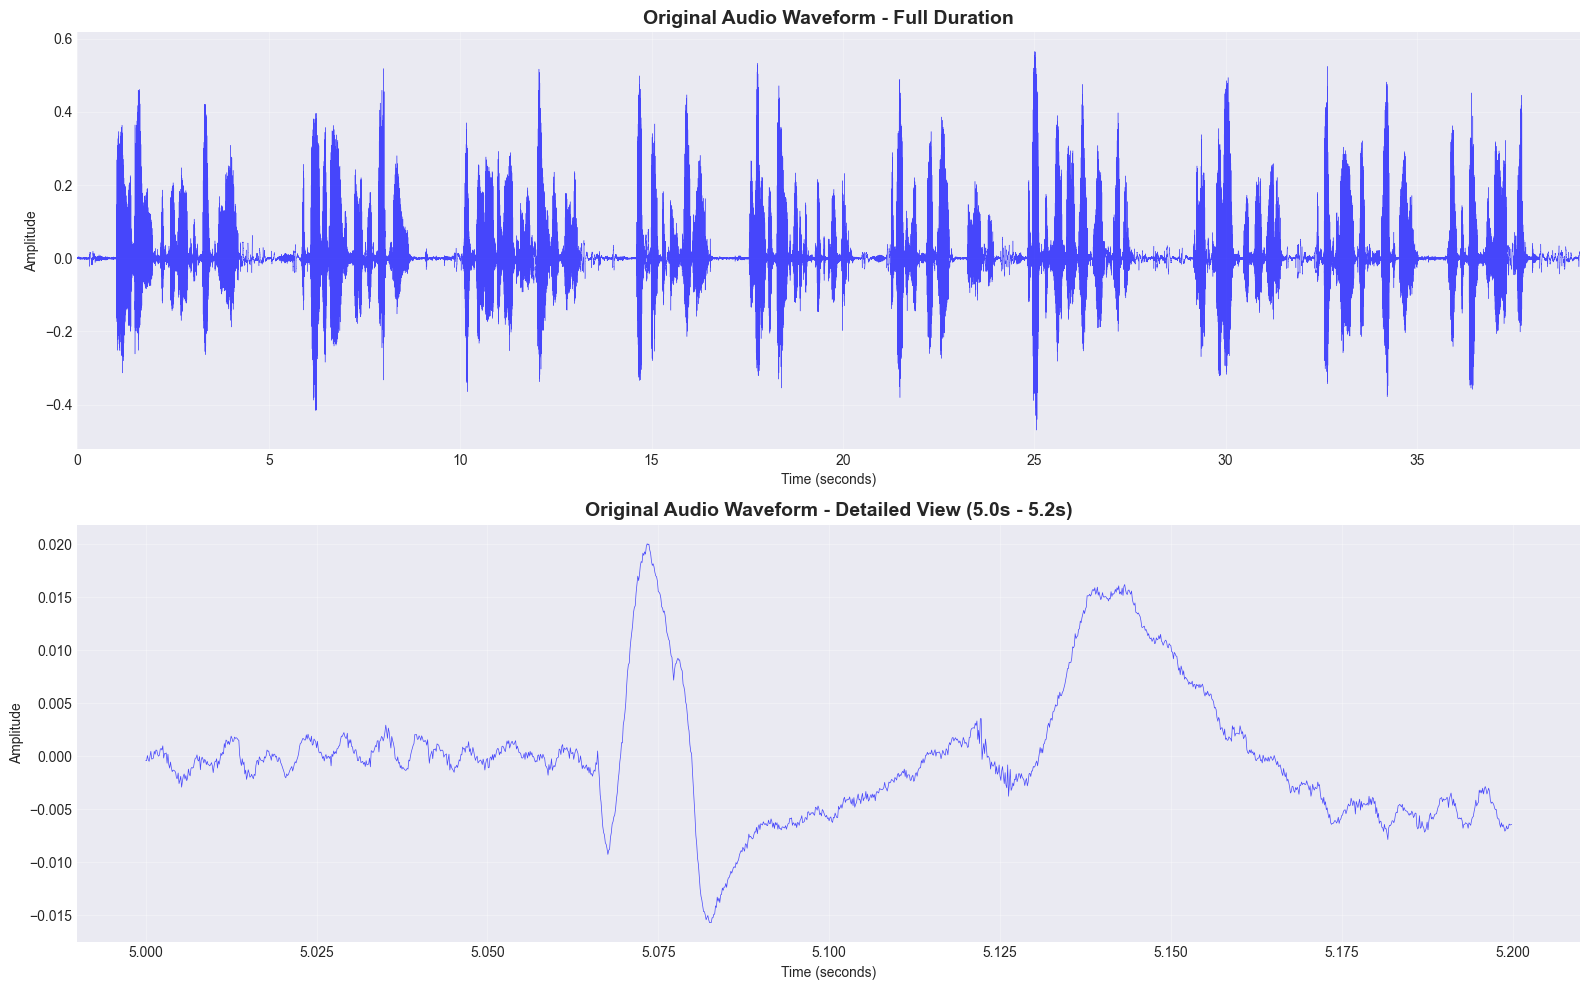

In [11]:

time_axis = np.arange(len(audio_norm)) / sample_rate


duration = len(audio_norm) / sample_rate


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

ax1.plot(time_axis, audio_norm, linewidth=0.3, color='blue', alpha=0.7)
ax1.set_title('Original Audio Waveform - Full Duration', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, time_axis[-1])
start_time = 5.0
duration_to_plot = 0.2
start_sample = int(start_time * sample_rate)
end_sample = int((start_time + duration_to_plot) * sample_rate)
time_region = time_axis[start_sample:end_sample]
audio_region = audio_norm[start_sample:end_sample]

ax2.plot(time_region, audio_region, linewidth=0.5, color='blue', alpha=0.7)
ax2.set_title(f'Original Audio Waveform - Detailed View ({start_time}s - {start_time + duration_to_plot}s)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Watermark Bit Sequence Visualization
Decode and visualize the embedded watermark bits: pilot pattern (8 bits) and message length (16 bits).


In [12]:
# Extract one frame for FFT analysis
frame_len = 256  # 32ms at 8kHz
start_sample = 0  # Start of first frame

frame_orig = audio_norm[start_sample:start_sample + frame_len]
frame_wm = audio_wm_norm[start_sample:start_sample + frame_len]

# Compute FFT
fft_orig = rfft(frame_orig)
fft_wm = rfft(frame_wm)

# Get magnitudes
magnitude_orig = np.abs(fft_orig)
magnitude_wm = np.abs(fft_wm)

# Calculate magnitude ratio (watermarked / original) for watermark bins
watermark_bins = 24  # 8 pilot bits + 16 length bits
ratio = np.zeros(watermark_bins)

for i in range(watermark_bins):
    bin_idx = 10 + i  # Watermark starts at bin 10
    if bin_idx < len(magnitude_orig) and magnitude_orig[bin_idx] > 1e-6:
        ratio[i] = magnitude_wm[bin_idx] / magnitude_orig[bin_idx]
    else:
        ratio[i] = 1.0

# Decode bits (threshold at 1.0)
threshold = 1.0
decoded_bits = (ratio > threshold).astype(int)

# Pilot pattern (expected)
pilot_pattern = [0, 1, 0, 1, 0, 1, 0, 1]

# Decode length header (16 bits after pilot)
length_bits = decoded_bits[8:24]
message_length = 0
for bit in length_bits:
    message_length = (message_length << 1) | bit

print(f"Decoded pilot pattern: {decoded_bits[:8].tolist()}")
print(f"Expected pilot pattern: {pilot_pattern}")
print(f"Message length: {message_length} bytes")
print(f"Total watermark bits shown: {watermark_bins}")


Decoded pilot pattern: [0, 1, 0, 1, 0, 1, 0, 1]
Expected pilot pattern: [0, 1, 0, 1, 0, 1, 0, 1]
Message length: 2 bytes
Total watermark bits shown: 24


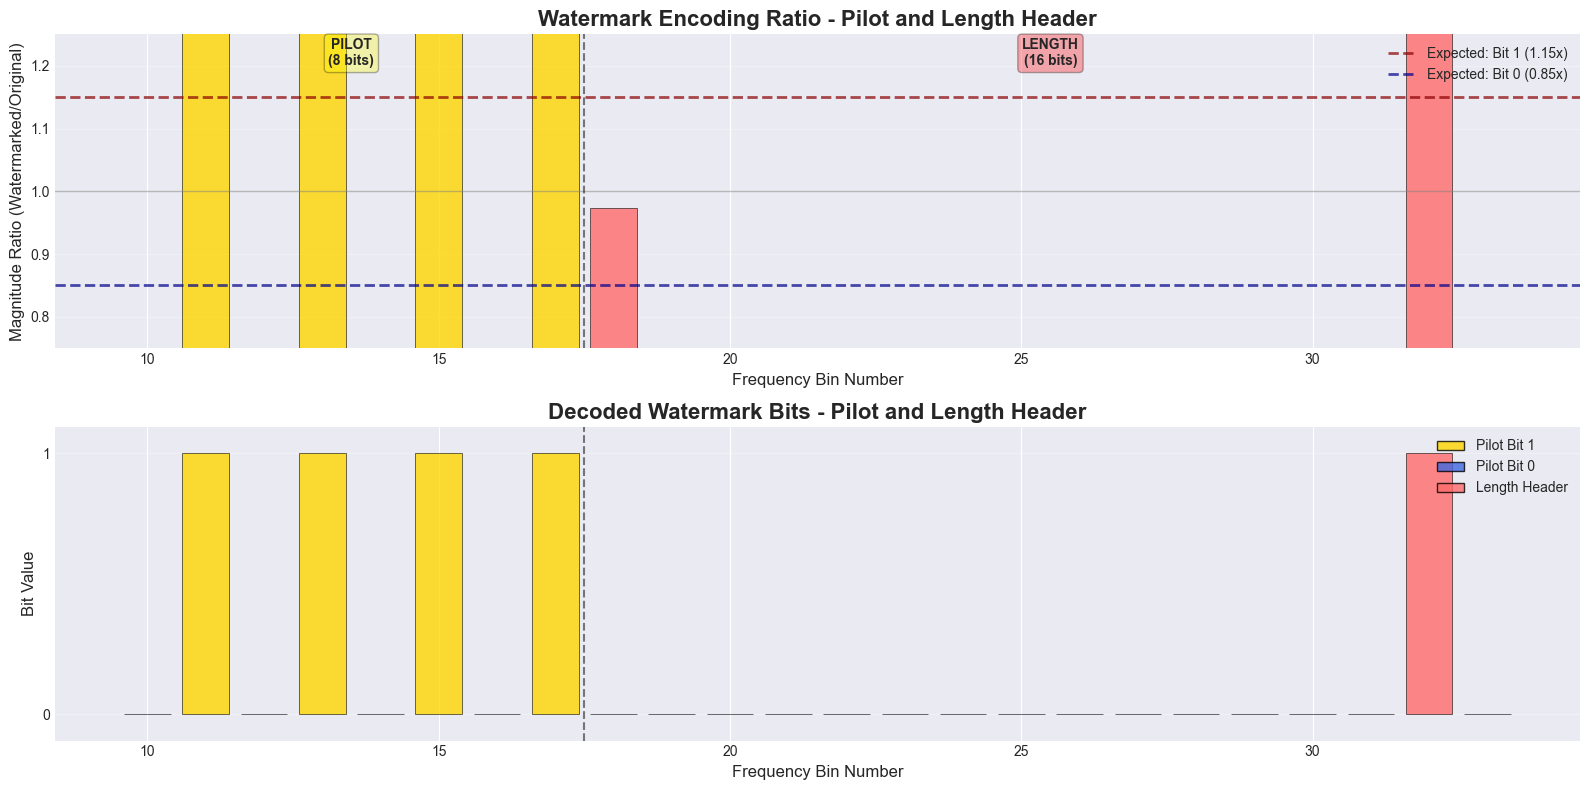


✓ Bit sequence visualization complete!
Pilot verification: 8/8 bits match


In [13]:
# Visualize the bit sequence
bin_numbers = np.arange(10, 10 + watermark_bins)

# Create color array for different sections
colors = []
for i in range(watermark_bins):
    if i < 8:  # Pilot bits
        colors.append('#FFD700' if pilot_pattern[i] == 1 else '#4169E1')  # Gold/RoyalBlue
    else:  # Length header
        colors.append('#FF6B6B')  # Red

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Magnitude ratio visualization
bars1 = ax1.bar(bin_numbers, ratio[:watermark_bins], color=colors, alpha=0.8, 
                edgecolor='black', linewidth=0.5)

# Add reference lines
ax1.axhline(y=1.15, color='darkred', linestyle='--', linewidth=2, 
            label='Expected: Bit 1 (1.15x)', alpha=0.7)
ax1.axhline(y=0.85, color='darkblue', linestyle='--', linewidth=2, 
            label='Expected: Bit 0 (0.85x)', alpha=0.7)
ax1.axhline(y=1.0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

# Add section divider
ax1.axvline(x=17.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

ax1.set_title('Watermark Encoding Ratio - Pilot and Length Header', 
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Frequency Bin Number', fontsize=12)
ax1.set_ylabel('Magnitude Ratio (Watermarked/Original)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0.75, 1.25)

# Add section labels
ax1.text(13.5, 1.22, 'PILOT\n(8 bits)', ha='center', va='center', 
         fontsize=10, fontweight='bold', 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
ax1.text(25.5, 1.22, 'LENGTH\n(16 bits)', ha='center', va='center', 
         fontsize=10, fontweight='bold', 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

# Decoded bits visualization
bars2 = ax2.bar(bin_numbers, decoded_bits[:watermark_bins], color=colors, 
                alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_title('Decoded Watermark Bits - Pilot and Length Header', 
              fontsize=16, fontweight='bold')
ax2.set_xlabel('Frequency Bin Number', fontsize=12)
ax2.set_ylabel('Bit Value', fontsize=12)
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Add section divider
ax2.axvline(x=17.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Create custom legend for sections
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FFD700', alpha=0.8, edgecolor='black', label='Pilot Bit 1'),
    Patch(facecolor='#4169E1', alpha=0.8, edgecolor='black', label='Pilot Bit 0'),
    Patch(facecolor='#FF6B6B', alpha=0.8, edgecolor='black', label='Length Header')
]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print(f"\n✓ Bit sequence visualization complete!")
print(f"Pilot verification: {sum(decoded_bits[:8] == pilot_pattern)}/8 bits match")


## 32ms Frame Analysis - Time and Frequency Domain
Compare the original and watermarked audio in both time and frequency domains for a single 32ms frame.


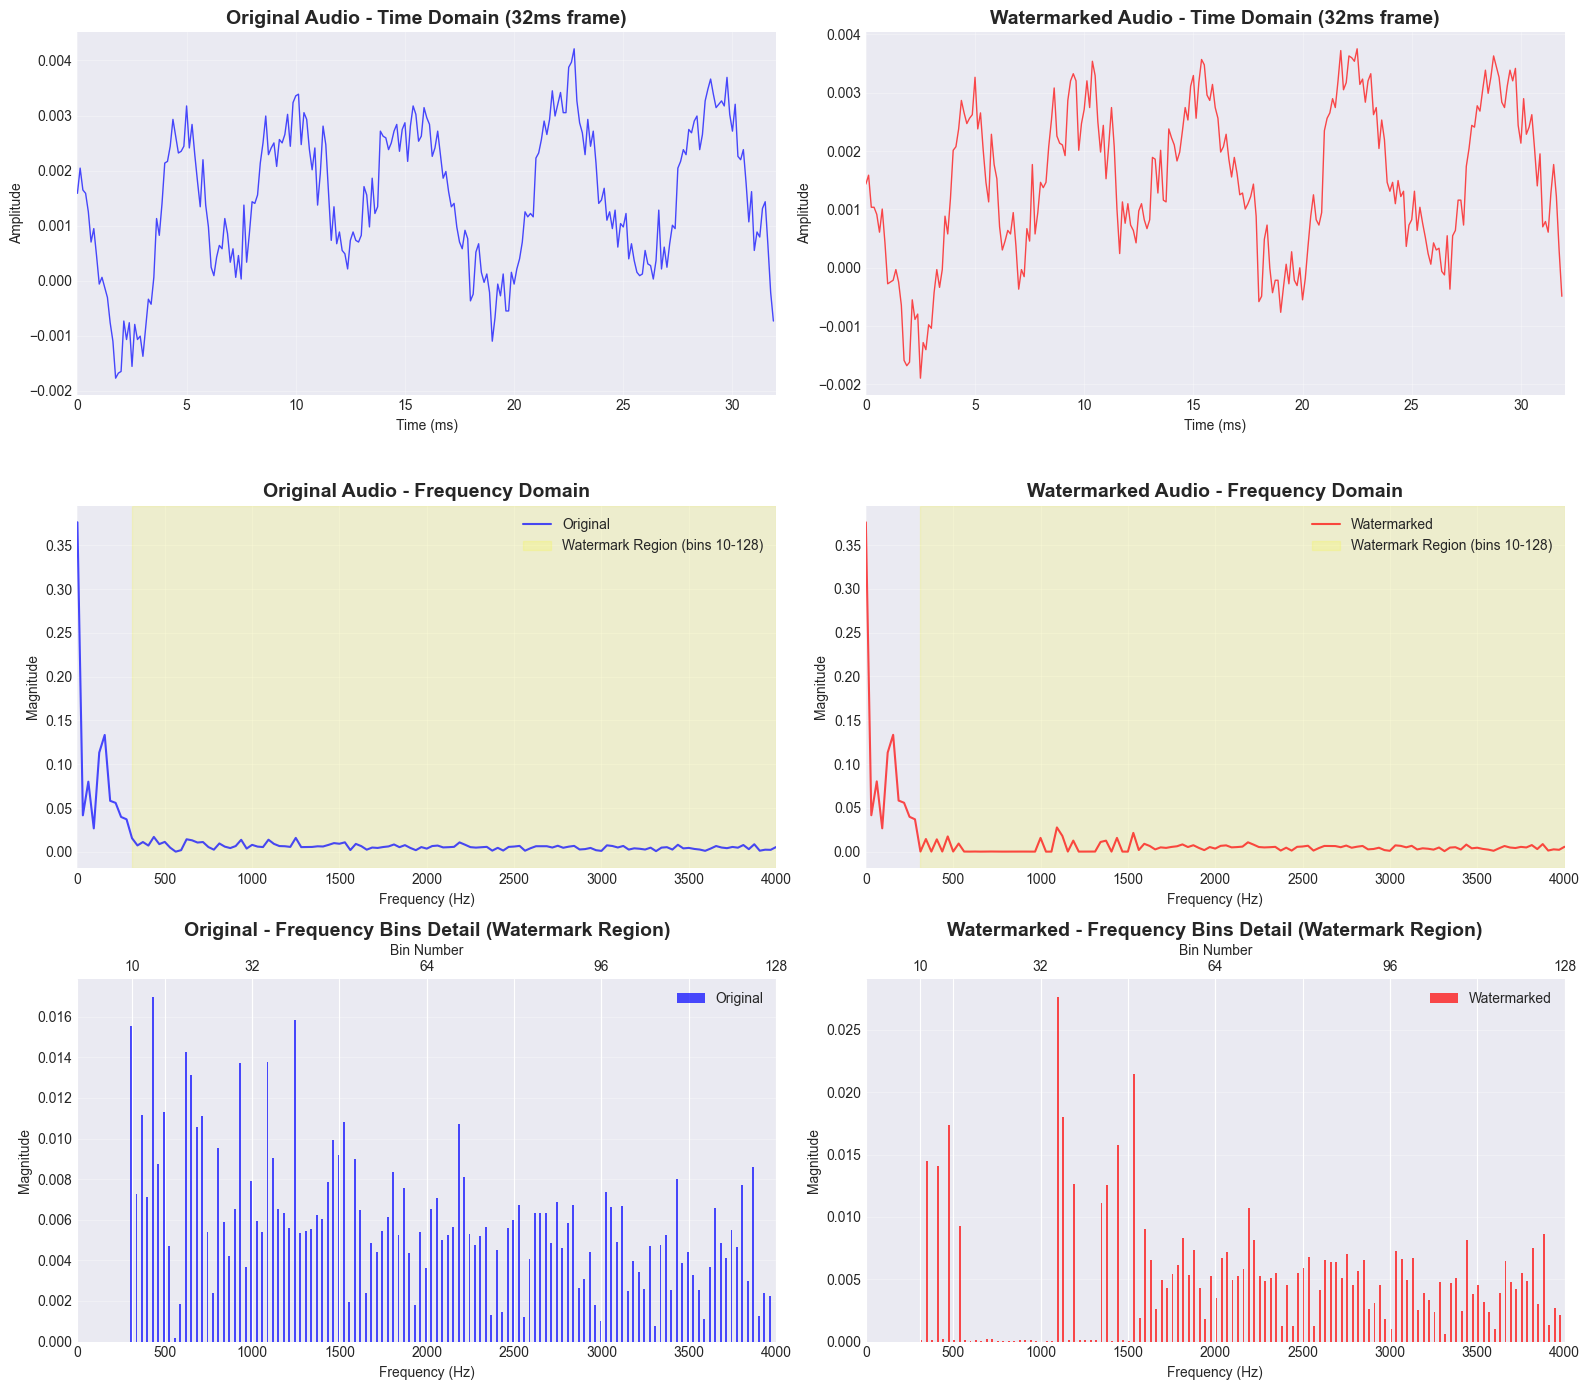


✓ 32ms frame visualization complete!
Frame length: 256 samples (32.0 ms)
Frequency resolution: 31.25 Hz per bin
Watermark region: 312.50 Hz - 4000.00 Hz
Detailed bin view shows bins 10-128 (full watermark region)


In [14]:
# Create time axis for the frame (32ms = 256 samples at 8kHz)
frame_time = np.arange(frame_len) / sample_rate * 1000  # Convert to milliseconds

# Frequency axis
frequencies = rfftfreq(frame_len, 1/sample_rate)

# Create 3x2 subplot layout
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 14))

# ===== TIME DOMAIN =====

# Original audio frame (time domain)
ax1.plot(frame_time, frame_orig, linewidth=1.0, color='blue', alpha=0.7)
ax1.set_title('Original Audio - Time Domain (32ms frame)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 32)

# Watermarked audio frame (time domain)
ax2.plot(frame_time, frame_wm, linewidth=1.0, color='red', alpha=0.7)
ax2.set_title('Watermarked Audio - Time Domain (32ms frame)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 32)

# ===== FREQUENCY DOMAIN =====

# Original audio frame (frequency domain)
ax3.plot(frequencies, magnitude_orig, linewidth=1.5, color='blue', alpha=0.7, label='Original')
ax3.axvspan(frequencies[10], frequencies[min(128, len(frequencies)-1)], 
            alpha=0.15, color='yellow', label='Watermark Region (bins 10-128)')
ax3.set_title('Original Audio - Frequency Domain', fontsize=14, fontweight='bold')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 4000)

# Watermarked audio frame (frequency domain)
ax4.plot(frequencies, magnitude_wm, linewidth=1.5, color='red', alpha=0.7, label='Watermarked')
ax4.axvspan(frequencies[10], frequencies[min(128, len(frequencies)-1)], 
            alpha=0.15, color='yellow', label='Watermark Region (bins 10-128)')
ax4.set_title('Watermarked Audio - Frequency Domain', fontsize=14, fontweight='bold')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 4000)

# ===== FREQUENCY BINS DETAIL (Watermark Region) =====

# Show detailed view of bins 10-128 (watermark region)
watermark_start_bin = 10
watermark_end_bin = min(128, len(magnitude_orig))

bins_to_show = np.arange(watermark_start_bin, watermark_end_bin)
freq_to_show = frequencies[bins_to_show]

# Bar width
width = (frequencies[1] - frequencies[0]) * 0.35

# Original bins
ax5.bar(freq_to_show - width/2, magnitude_orig[bins_to_show], 
        width=width, label='Original', alpha=0.7, color='blue')
ax5.set_title('Original - Frequency Bins Detail (Watermark Region)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('Magnitude')
ax5.legend(loc='upper right')
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_xlim(0, 4000)  # Match frequency domain scale

# Add bin numbers as secondary x-axis
ax5_top = ax5.twiny()
ax5_top.set_xlim(ax5.get_xlim())
ax5_top.set_xlabel('Bin Number')
# Show bin numbers at regular intervals
tick_positions = [312.5, 1000, 2000, 3000, 4000]  # Frequencies for tick marks
tick_bins = [10, 32, 64, 96, 128]  # Corresponding bin numbers
ax5_top.set_xticks(tick_positions)
ax5_top.set_xticklabels(tick_bins)

# Watermarked bins
ax6.bar(freq_to_show + width/2, magnitude_wm[bins_to_show], 
        width=width, label='Watermarked', alpha=0.7, color='red')
ax6.set_title('Watermarked - Frequency Bins Detail (Watermark Region)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Frequency (Hz)')
ax6.set_ylabel('Magnitude')
ax6.legend(loc='upper right')
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_xlim(0, 4000)  # Match frequency domain scale

# Add bin numbers as secondary x-axis
ax6_top = ax6.twiny()
ax6_top.set_xlim(ax6.get_xlim())
ax6_top.set_xlabel('Bin Number')
ax6_top.set_xticks(tick_positions)
ax6_top.set_xticklabels(tick_bins)

plt.tight_layout()
plt.show()

print(f"\n✓ 32ms frame visualization complete!")
print(f"Frame length: {frame_len} samples ({frame_len/sample_rate*1000:.1f} ms)")
print(f"Frequency resolution: {frequencies[1] - frequencies[0]:.2f} Hz per bin")
print(f"Watermark region: {frequencies[10]:.2f} Hz - {frequencies[min(128, len(frequencies)-1)]:.2f} Hz")
print(f"Detailed bin view shows bins {watermark_start_bin}-{watermark_end_bin} (full watermark region)")


## Pilot Pattern Calibration
The pilot pattern (alternating 0, 1, 0, 1, 0, 1, 0, 1) serves as a reference to calibrate the decoding threshold.
Since we know the expected pattern, we can verify the watermark and set the correct threshold for decoding the message.


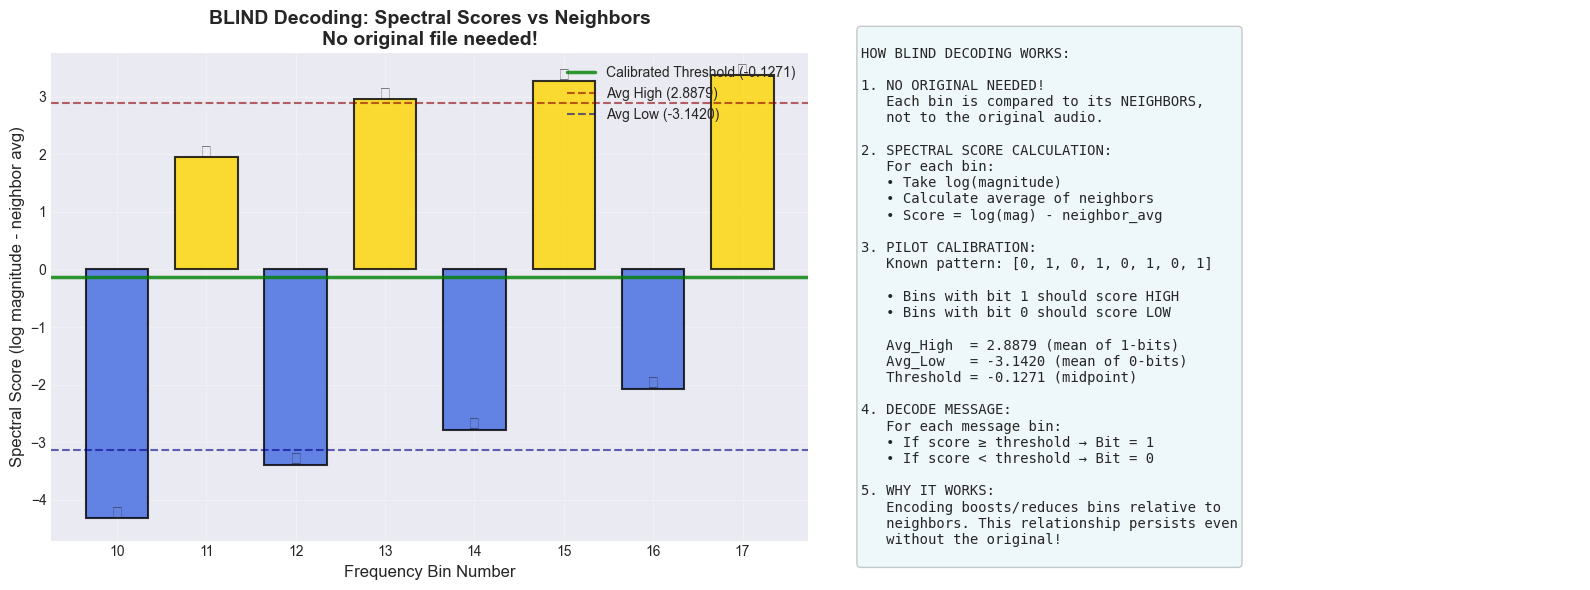


✓ BLIND decoding calibration complete!
Spectral scores (pilot bins): ['-4.3231', '1.9457', '-3.3873', '2.9582', '-2.7816', '3.2759', '-2.0762', '3.3718']
Average HIGH score: 2.8879
Average LOW score:  -3.1420
Calibrated threshold: -0.1271

Decoded pilot (blind): [0, 1, 0, 1, 0, 1, 0, 1]
Expected pilot:        [0, 1, 0, 1, 0, 1, 0, 1]
Accuracy: 8/8 = 100%


In [ ]:
# Pilot pattern analysis
pilot_bins = np.arange(10, 18)  # Bins 10-17 (8 pilot bits)
pilot_freq = frequencies[pilot_bins]
pilot_ratio = ratio[:8]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Show the calibration concept
colors_pilot = ['#4169E1' if bit == 0 else '#FFD700' for bit in pilot_pattern]
bars = ax1.bar(pilot_bins, pilot_ratio, color=colors_pilot, alpha=0.8, 
               edgecolor='black', linewidth=1.5, width=0.7)

# Add reference lines
ax1.axhline(y=1.15, color='darkred', linestyle='--', linewidth=2.5, 
            label='Expected Bit 1 (1.15x)', alpha=0.8)
ax1.axhline(y=0.85, color='darkblue', linestyle='--', linewidth=2.5, 
            label='Expected Bit 0 (0.85x)', alpha=0.8)
ax1.axhline(y=1.0, color='green', linestyle='-', linewidth=2, 
            label='Threshold (1.0)', alpha=0.8)

ax1.set_title('Pilot Pattern Calibration\nKnown sequence validates watermark', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency Bin Number', fontsize=12)
ax1.set_ylabel('Magnitude Ratio (Watermarked/Original)', fontsize=12)
ax1.set_ylim(0.7, 1.3)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Add annotations showing expected vs actual
for i, (bin_num, ratio_val, expected) in enumerate(zip(pilot_bins, pilot_ratio, pilot_pattern)):
    expected_val = 1.15 if expected == 1 else 0.85
    match = '✓' if (ratio_val > 1.0) == expected else '✗'
    ax1.text(bin_num, ratio_val + 0.05, f'{match}', ha='center', fontsize=12, fontweight='bold')

# Right: Show the concept
ax2.axis('off')
explanation_text = """
HOW PILOT PATTERN CALIBRATION WORKS:

1. KNOWN SEQUENCE:
   Pilot = [0, 1, 0, 1, 0, 1, 0, 1]
   
2. ENCODING:
   • Bit 0 → Magnitude × 0.85 (reduced)
   • Bit 1 → Magnitude × 1.15 (boosted)
   
3. DECODING:
   • Calculate ratio = Watermarked/Original
   • If ratio > 1.0 → Decoded as 1
   • If ratio < 1.0 → Decoded as 0
   
4. VERIFICATION:
   Compare decoded pilot to expected [0,1,0,1,0,1,0,1]
   If match → Watermark valid ✓
   If mismatch → No watermark or corrupted ✗
   
5. CALIBRATION:
   The threshold (1.0) can be adjusted based
   on pilot pattern accuracy to account for
   audio processing or noise.
"""

ax2.text(0.1, 0.5, explanation_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print(f"\n✓ Pilot calibration visualization complete!")
print(f"Pilot bins: {pilot_bins.tolist()}")
print(f"Pilot frequencies: {[f'{f:.1f} Hz' for f in pilot_freq]}")
print(f"Pilot ratios: {[f'{r:.3f}' for r in pilot_ratio]}")
print(f"Decoded pilot: {decoded_bits[:8].tolist()}")
print(f"Expected pilot: {pilot_pattern}")
matches = sum(decoded_bits[:8] == pilot_pattern)
print(f"Accuracy: {matches}/8 bits = {matches/8*100:.1f}%")


## Binary Encoding Through Relative Magnitude
How 1s and 0s are encoded by modifying the relative magnitude of frequency bins.


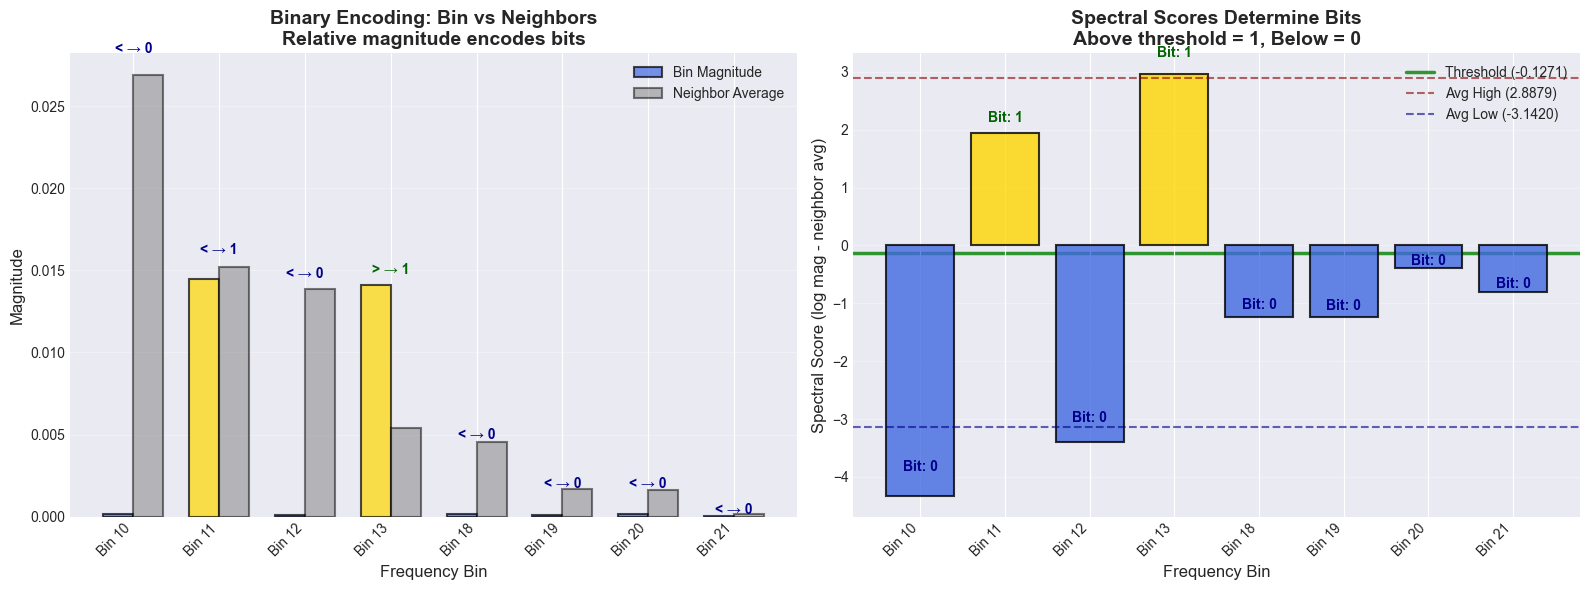


✓ Binary encoding visualization complete!

Example bins analysis (BLIND decoding):
  Bin 10: Mag=0.00015 LOWER than neighbors (0.02688) → Score=-4.3231 → Bit: 0
  Bin 11: Mag=0.01445 LOWER than neighbors (0.01522) → Score=1.9457 → Bit: 1
  Bin 12: Mag=0.00013 LOWER than neighbors (0.01387) → Score=-3.3873 → Bit: 0
  Bin 13: Mag=0.01410 HIGHER than neighbors (0.00541) → Score=2.9582 → Bit: 1
  Bin 18: Mag=0.00015 LOWER than neighbors (0.00453) → Score=-1.2293 → Bit: 0
  Bin 19: Mag=0.00008 LOWER than neighbors (0.00167) → Score=-1.2423 → Bit: 0
  Bin 20: Mag=0.00017 LOWER than neighbors (0.00166) → Score=-0.3845 → Bit: 0
  Bin 21: Mag=0.00006 LOWER than neighbors (0.00014) → Score=-0.8103 → Bit: 0


In [ ]:
# Select example bins to demonstrate encoding (pilot + some message bits)
example_bins = [10, 11, 12, 13, 18, 19, 20, 21]  # Mix of 0s and 1s
example_labels = ['Bit 0\n(Pilot)', 'Bit 1\n(Pilot)', 'Bit 0\n(Pilot)', 'Bit 1\n(Pilot)',
                  'Bit 0\n(Length)', 'Bit 1\n(Length)', 'Bit 0\n(Length)', 'Bit 0\n(Length)']
actual_bits = decoded_bits[np.array(example_bins) - 10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ===== LEFT: Side-by-side magnitude comparison =====
x_pos = np.arange(len(example_bins))
width = 0.35

# Original magnitudes
orig_mags = magnitude_orig[example_bins]
wm_mags = magnitude_wm[example_bins]

bars1 = ax1.bar(x_pos - width/2, orig_mags, width, label='Original', 
                alpha=0.7, color='blue', edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, wm_mags, width, label='Watermarked', 
                alpha=0.7, color='red', edgecolor='black')

ax1.set_title('Magnitude Comparison: Original vs Watermarked\nRelative change encodes binary information', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency Bin', fontsize=12)
ax1.set_ylabel('Magnitude', fontsize=12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'Bin {b}' for b in example_bins], rotation=45, ha='right')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')

# Add arrows and labels showing the encoding
for i, (bin_num, orig_mag, wm_mag, bit_val) in enumerate(zip(example_bins, orig_mags, wm_mags, actual_bits)):
    if wm_mag > orig_mag:
        # Bit 1 - arrow pointing up
        ax1.annotate('', xy=(i, wm_mag), xytext=(i, orig_mag),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2))
        ax1.text(i, max(wm_mag, orig_mag) + 0.002, '↑ 1', ha='center', 
                fontsize=10, fontweight='bold', color='darkgreen')
    else:
        # Bit 0 - arrow pointing down
        ax1.annotate('', xy=(i, wm_mag), xytext=(i, orig_mag),
                    arrowprops=dict(arrowstyle='->', color='darkblue', lw=2))
        ax1.text(i, max(wm_mag, orig_mag) + 0.002, '↓ 0', ha='center', 
                fontsize=10, fontweight='bold', color='darkblue')

# ===== RIGHT: Ratio-based encoding explanation =====
ratios_example = ratio[np.array(example_bins) - 10]
colors_example = ['#4169E1' if r < 1.0 else '#FFD700' for r in ratios_example]

bars3 = ax2.bar(x_pos, ratios_example, color=colors_example, alpha=0.8, 
                edgecolor='black', linewidth=1.5)

ax2.axhline(y=1.0, color='green', linestyle='-', linewidth=2.5, 
            label='Threshold = 1.0', alpha=0.8, zorder=0)
ax2.axhline(y=1.15, color='darkred', linestyle='--', linewidth=1.5, 
            label='Target for Bit 1', alpha=0.6)
ax2.axhline(y=0.85, color='darkblue', linestyle='--', linewidth=1.5, 
            label='Target for Bit 0', alpha=0.6)

ax2.set_title('Ratio-Based Binary Encoding\nThreshold determines bit value', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency Bin', fontsize=12)
ax2.set_ylabel('Magnitude Ratio (Watermarked/Original)', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Bin {b}' for b in example_bins], rotation=45, ha='right')
ax2.set_ylim(0.7, 1.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add decoded bit labels
for i, (ratio_val, bit_val) in enumerate(zip(ratios_example, actual_bits)):
    ax2.text(i, ratio_val + 0.05, f'Bit: {bit_val}', ha='center', 
            fontsize=10, fontweight='bold', 
            color='darkgreen' if bit_val == 1 else 'darkblue')

plt.tight_layout()
plt.show()

print(f"\n✓ Binary encoding visualization complete!")
print(f"\nExample bins analysis:")
for bin_num, orig_mag, wm_mag, ratio_val, bit_val, label in zip(
    example_bins, orig_mags, wm_mags, ratios_example, actual_bits, example_labels):
    change = "BOOSTED" if wm_mag > orig_mag else "REDUCED"
    print(f"  Bin {bin_num} ({label.strip()}): Ratio={ratio_val:.3f} → {change} → Decoded bit: {bit_val}")
